# Exploration des données

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats 
import numpy
import seaborn as sns

### Import et présentation des données

In [50]:
path = './data'
x_data = pd.read_csv(path+'/Xtrain_hgcGIrA.csv', sep=',') # features
y_data = pd.read_csv(path+'/Ytrain_yL5OjS4.csv', sep=',', usecols=[1]) # occupancy rate

data = pd.merge(
    x_data,
    y_data,
    how="inner",
    left_index=True,
    right_index=True,
    copy=True,
    indicator=False,
    validate=None,
) # merged dataframe

data

,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
0,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091,0.216
1,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106,0.216
2,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111,0.227
3,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108,0.229
4,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096,0.225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN,0.111
31115,2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN,0.143
31116,2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN,0.139
31117,2019-03-21,9,0,BE,08:00:00,2,0.182,0.19300,0.162000,0.074,0.101,NaN,0.117


Notre dataset d'entraînement comporte 31118 échantillons. Pour chaque ligne, on dispose des 12 features suivantes :
1. La date du jour où le trajet a lieu
2. Le numéro du train considéré de 1 à 55
3. Le sens de parcours - 0 pour dire vers Paris / 1 pour dire vers depuis Paris
4. L'identifiant de la gare où s'arrête le train
5. L'heure à laquelle le train s'arrête à la gare
6. Le nombre de rames du train (1 ou 2)
7-9. p1q0, p2q0, p3q0 : respectivement le taux d'occupation du dernier train, avant-dernier et avant-avant-dernier train au même arrêt
10-12. p0q1, p0q2, p0q3 : respectivement le taux d'occupation du même train au dernier arrêt, avant-dernier et avant-avant-dernier arrêt

On dispose aussi d'une colonne cible p0q0 : le taux d'occupation du train courant à l'arrêt courant.

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         31119 non-null  object 
 1   train        31119 non-null  int64  
 2   way          31119 non-null  int64  
 3   station      31119 non-null  object 
 4   hour         27915 non-null  object 
 5   composition  31119 non-null  int64  
 6   p1q0         29067 non-null  float64
 7   p2q0         26974 non-null  float64
 8   p3q0         24935 non-null  float64
 9   p0q1         27917 non-null  float64
 10  p0q2         24720 non-null  float64
 11  p0q3         21527 non-null  float64
 12  p0q0         31119 non-null  float64
dtypes: float64(7), int64(3), object(3)
memory usage: 3.1+ MB


Afin de pouvoir mieux étudier notre dataset, nous allons rectifier certains typages fait par pandas qui ne sont pas appropriés : en effet, train et way, même si ce sont bien des entiers, doivent être considérés comme des variables catégorielles.

In [52]:
data['train'] = data['train'].astype('category')
data['way'] = data['way'].astype('category')

Il faut aussi changer le format de date.

In [69]:
data['date'] = pd.to_datetime(data['date'])

### Étude des données

#### Gestion des NaN

In [54]:
pd.isna(data).sum()

date              0
train             0
way               0
station           0
hour           3204
composition       0
p1q0           2052
p2q0           4145
p3q0           6184
p0q1           3202
p0q2           6399
p0q3           9592
p0q0              0
dtype: int64

In [55]:
data.loc[data['hour'].isna()] 

,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
406,2019-01-07,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.045
407,2019-01-08,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.044
408,2019-01-10,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.061
409,2019-01-11,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.042
410,2019-01-14,1,0,AX,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30938,2019-05-13,9,0,AX,NaN,2,0.0840,0.110822,0.0970,NaN,NaN,NaN,0.080
30939,2019-05-14,9,0,AX,NaN,2,0.0940,0.100000,0.1190,NaN,NaN,NaN,0.089
30940,2019-05-15,9,0,AX,NaN,2,0.0910,0.085000,0.1060,NaN,NaN,NaN,0.099
30941,2019-03-21,9,0,AX,NaN,2,0.1070,0.107000,0.0950,NaN,NaN,NaN,0.074


Une des spécificités de notre dataset est le nombre très important de valeurs manquantes. Les colonnes concernées sont hour, p1q0, p2q0, p3q0, p0q1, p0q2, et p0q3.
La SNCF explique cela par le fait que les valeurs sont inexistantes à cause de la structure de leur grille horaire.

Plusieurs algorithmes de Machine Learning n'autorise pas des datasets avec des valeurs manquantes. Il faut donc que nous trouvions un moyen de contourner ce problème.

- Si on décide de supprimer toutes les lignes avec des valeurs NaN :

In [56]:
data_no_na = data.dropna()
data_no_na.shape

(17666, 13)

In [57]:
other_data_no_na = data.drop(labels=['p0q3', "p3q0"], axis = 1)
other_data_no_na = other_data_no_na.dropna()
other_data_no_na.shape

(21513, 11)

Si on choisit de supprimer toutes les lignes avec des valeurs NaN, on perd 43,23% des données de notre dataset. 17 666 reste un nombre important d'échantillons mais il faudrait mieux trouver un autre moyen car les lignes avec des données manquantes ont aussi des données non manquantes utiles.
On peut aussi choisir de supprimer des colonnes, par exemple p0q3 et p3q0, qui sont les données les plus "éloignées" et qui ont un nombre important de NaN. Avec cela, on conserve 21 513 lignes ce qui correspond à 215 130 données contre 211 992 données pour la solution précédente.

Il faudra cependant adapter la situation à l'algorithme choisi.

- Si on décide de ne pas supprimer les lignes avec des NaN :

Supprimer les valeurs NaN de notre dataset conduit à beaucoup de pertes, celles-ci étant nombreuses. Une meilleure option serait de faire avec ces valeurs NaN, en adaptant les algorithmes utilisés par exemple : certains acceptent des datasets avec des NaN. Cela réduit cependant notre champ d'action.    
Une autre possibilité est de compléter nos valeurs manquantes par régression linéaire, dans le cas où on dispose d'autres variables très corrélées. Cela pourrait marcher, sauf pour les horaires. Le fait que les pxqx soient NaN quand les arrêts et trains considérés n'existent pas pourrait aussi nous faire envisager de remplacer NaN par zéro dans ces colonnes.

Source : https://larevueia.fr/4-methodes-pour-gerer-les-donnees-manquantes-en-machine-learning-avec-pandas/

#### Statistiques chiffrés

##### Variables quantitatives

In [58]:
data.describe()

,date,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
count,31119,31119.000000,29067.000000,26974.000000,24935.000000,27917.000000,24720.000000,21527.000000,31119.000000
mean,2019-03-07 05:09:45.481538560,1.999647,0.234769,0.251392,0.316867,0.207200,0.222167,0.209845,0.248754
min,2019-01-07 00:00:00,1.000000,0.000000,0.000000,0.000000,0.004000,0.004000,0.004000,0.000000
25%,2019-01-31 00:00:00,2.000000,0.094000,0.136000,0.196000,0.099000,0.107000,0.100000,0.121000
50%,2019-03-12 00:00:00,2.000000,0.192000,0.230000,0.312000,0.181000,0.188000,0.172000,0.220000
75%,2019-04-05 00:00:00,2.000000,0.363000,0.354000,0.420000,0.294000,0.322000,0.292000,0.360500
max,2019-05-20 00:00:00,2.000000,0.934000,0.937000,0.937000,0.969000,0.974000,0.974000,0.974000
std,NaN,0.018798,0.166153,0.143506,0.150974,0.134709,0.147600,0.144858,0.157367


Le tableau ci-dessus nous apprend notamment que :
- La majorité des trains qui circulent sont des trains à deux rames
- En moyenne, le taux d'occupation des trains tourne autour de 0,2/0,3. Des taux d'occupation de 0,9 sont très rares (75 pourcent des valeurs sont inférieures ou égales à 0,4 au maximum pour p3q0).

In [59]:
data.median(numeric_only=True)

composition    2.000
p1q0           0.192
p2q0           0.230
p3q0           0.312
p0q1           0.181
p0q2           0.188
p0q3           0.172
p0q0           0.220
dtype: float64

Les médianes confirment nos conclusions précédentes.

##### Variables qualitatives

In [60]:
data.describe(include=['object','category'])

,train,way,station,hour
count,31119,31119,31119,27915
unique,55,1,36,5
top,31,0,AJ,07:00:00
freq,833,31119,3204,10064


La tableau ci-dessus nous informe que le dataset comprends des données pour 74 jours et 5 plages horaires différentes, 55 trains (comme prévu), 36 gares et 1 sens de circulation. Nous allons confirmer les deux valeurs faibles en diversité : way et hour.

In [61]:
data['way'].value_counts().sort_values(ascending=False)

way
0    31119
Name: count, dtype: int64

Contrairement à ce que laissait pensait la description du dataset sur le site du Challenge Data, on ne dispose pas d'échantillons de train allant de Paris à la banlieue. Ainsi, il ne servira à rien de considérer way dans notre entraînement car cette information ne nous apportera rien.

In [62]:
data['hour'].value_counts().sort_values(ascending=False)

hour
07:00:00    10064
08:00:00    10028
06:00:00     4995
09:00:00     2826
11:00:00        2
Name: count, dtype: int64

Les plages horaires considérées correspondent uniquement au matin, et les périodes de départ au travail sont le plus représentées. La plage horaire de 11 à 12h est presque non-représentée.

In [63]:
data['date'].min(), data['date'].max()

(Timestamp('2019-01-07 00:00:00'), Timestamp('2019-05-20 00:00:00'))

Les données ont été récoltées pour les mois de janvier à mai 2019.

#### Plots

##### Distribution

- Histogrammes des valeurs quantitatives

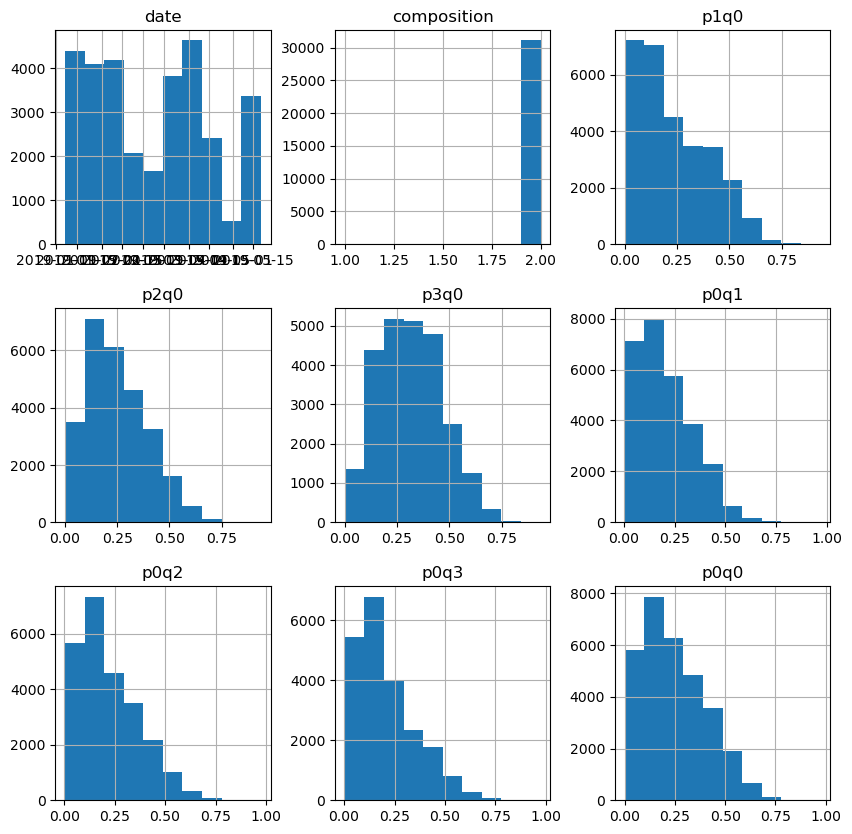

In [64]:
data.hist(figsize=(10,10));

En terme de valeurs plus courantes, les histogrammes confirment nos déductions de la partie Statistiques chiffrées. Ils permettent aussi de déceler une forte corrélation dans la distribution de la plupart des valeurs pxqx, à l'exception de p3q0 qui semble un peu plus éloigné.

- Barplot des valeurs quantitatives

In [65]:
frequencies = [pd.crosstab(data[name], "freq", normalize=True) for name in ['date', 'train', 'hour', 'station']]

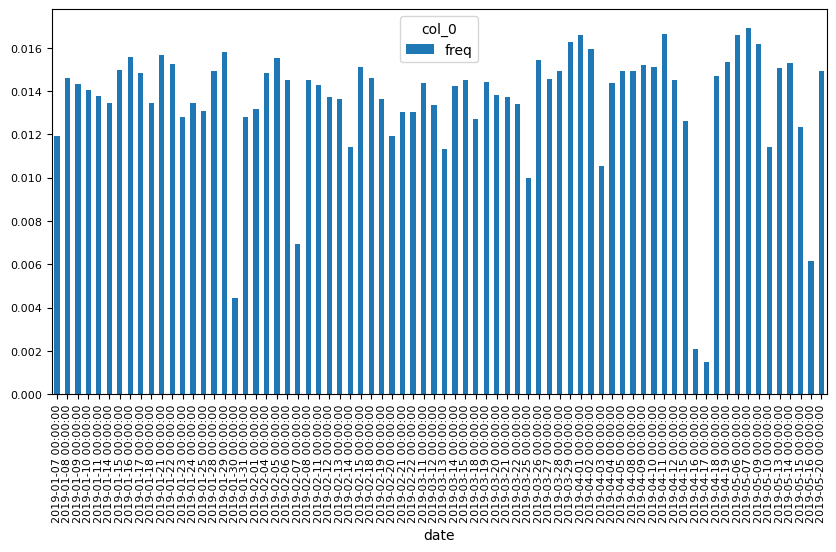

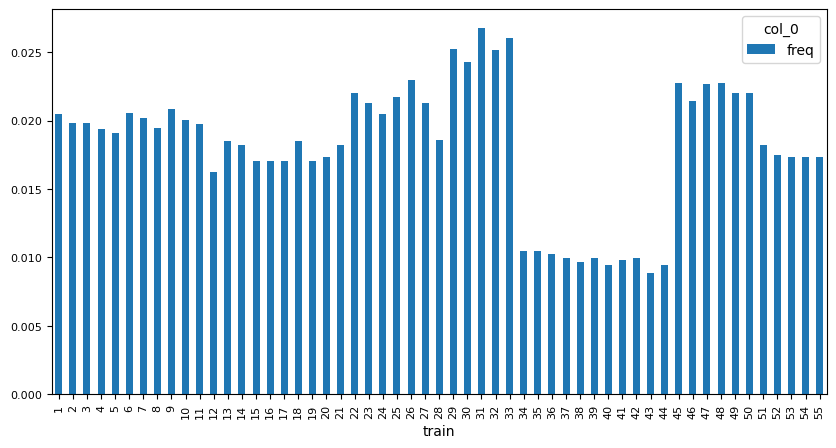

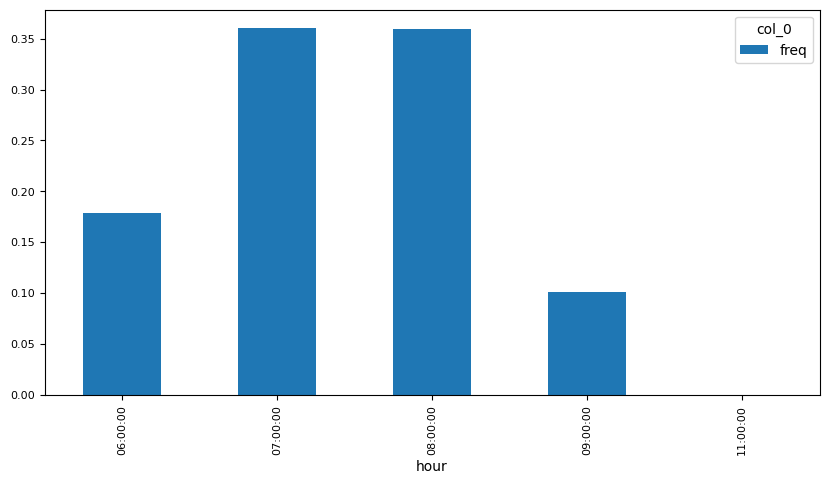

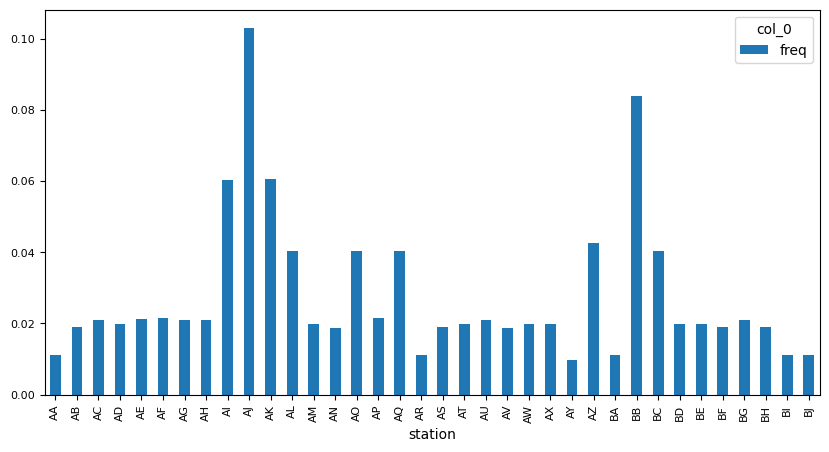

In [66]:
for f in frequencies :
    f.plot.bar(figsize = (10,5), fontsize=8)
plt.show()

Les barplots ci-dessus confirment la plupart des conclusions tirées à l'étape des statistiques chiffrées. On remarque que certaines dates et certains arrêt sont moins présents dans le dataset, mais il semble difficile de l'expliquer.

##### Étude du rapport entre p0q0 et les autres colonnes

- Variables quantitatives

In [84]:
corr = data[['p0q0','p1q0','p0q1','p2q0','p0q2','p3q0','p0q3']].corr()

<Axes: >

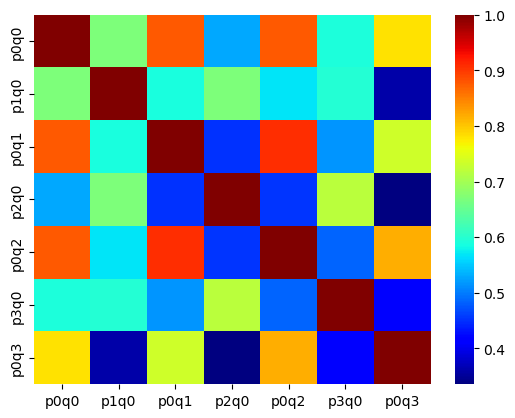

In [86]:
sns.heatmap(corr, cmap='jet')

La matrice de corrélation ci-dessus nous montre que p0q0 est plutôt corrélé avec l'ensemble des pxqx, puisque qu'on ne descend pas sous 50%. La corrélation la plus faible est avec p2q0 et p3q0, et la plus forte avec p0q1 et p0q2.

- Variables qualitatives

1. Date

Par soucis de lisibilité, on ne peut pas tracer les boxplots de p0q0 en fonction de la date. On va donc plutôt essayer en fonction du jour de la semaine, du jour et du mois.

In [72]:
data['day_of_week'] = data['date'].dt.day_of_week
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month


/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


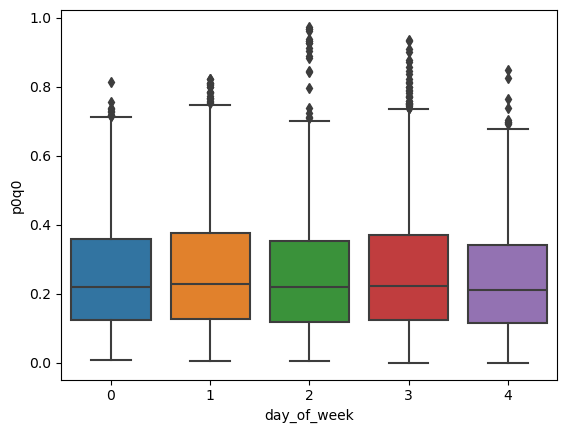

In [73]:
sns.boxplot(data = data, x='day_of_week', y='p0q0');

Globalement, le jour de la semiane ne semble par avoir de gros impact sur le taux d'occupation. On note que seuls les jours de semaine de travail classique (lundi au vendredi) sont considérés.

/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


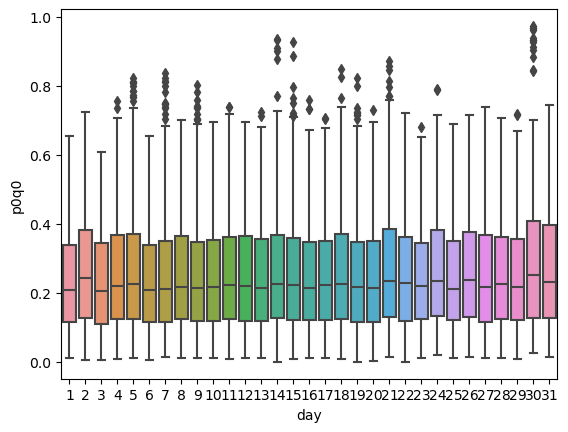

In [74]:
sns.boxplot(data = data, x='day', y='p0q0');

Il en est de même pour les jours du mois, aucun lien spécifique ne semble se dessiner. Le 30 et 31 du mois semblent entraîner des p0q0 un peu plus élevés, mais ce n'est pas flagrant.

/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


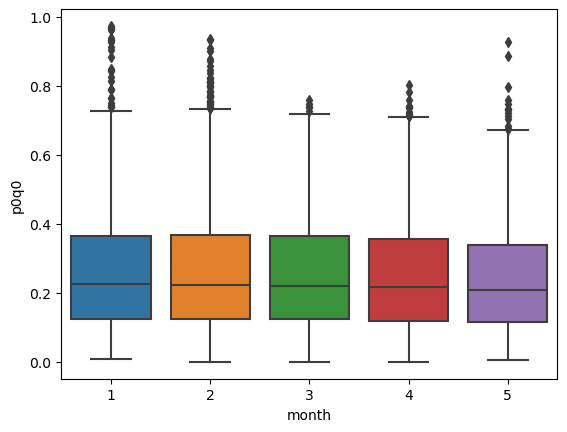

In [75]:
sns.boxplot(data = data, x='month', y='p0q0');

Comme le jour de la semaine et le jour du mois, on observe pas de gros impact du mois sur le taux d'occupation p0q0.

2. Train

/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


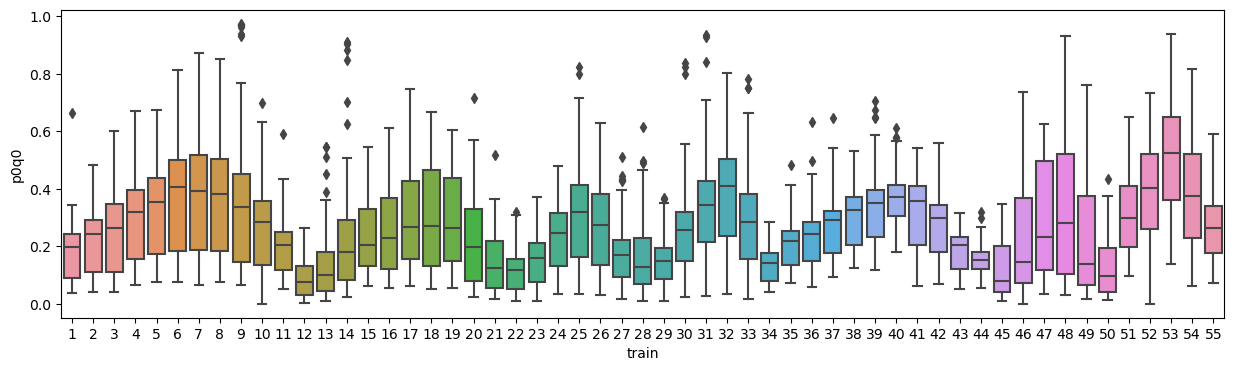

In [79]:
plt.figure(figsize=(15,4))
ax = sns.boxplot(data = data, x='train', y='p0q0', );

Le train considéré semble avoir un impact important sur le p0q0.

3. Station

/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


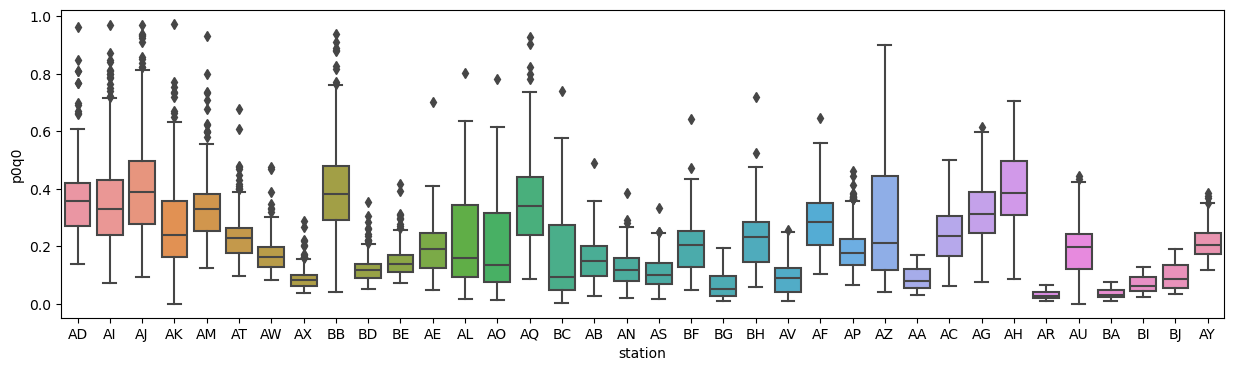

In [80]:
plt.figure(figsize=(15,4))
ax = sns.boxplot(data = data, x='station', y='p0q0', );

L'arrêt considéré influe aussi grandement sur p0q0. On remarque des arrêts avec très peu de variations dans les taux d'occupation (AX par exemple) et d'autres avec beaucoup plus (AL par exemple). De même, par exemple, sur l'arrêt BE, p0q0 tourne autour de moins de 0,2 contre autour de 0,4 pour AJ.

4. Hour

/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mcoutier/miniconda3/envs/STASC/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


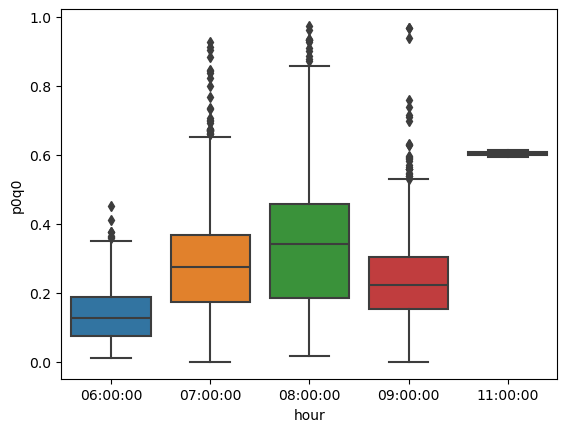

In [81]:
sns.boxplot(data = data, x='hour', y='p0q0', );

Pour ce qui est des plages horaires, on remarque aussi un impact sur p0q0, avec un taux d'occupation plus bas de 6h à 7h notamment, et en moyenne plus haut de 7 à 9h.

- Bilan

Les colonnes qui sont susceptibles d'avoir le plus d'impact dans la prédiction de nos taux d'occupation, d'après nos études sont : tous les pxqx, le train, la station et l'heure.